In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## MAIN TASK

In this coursework assignment, you are meant to value derivatives using binomial trees, Monte-Carlo
simulations, the finite difference method, and the Longstaff-Schwartz least-squares approach. To this
end, assume the following set of baseline parameters: The initial stock price (S0) is 35, the stock volatility is 0.45 (45% per annum), and the risk-free rate is 0.03 (3% per annum). Consider a European put
option whose strike price is equal to 35, with a time-to-maturity of one year. The dividend yield is 0.04
(4% per annum). In some later tasks, you also encounter the “equivalent” American option.

### Task 1

Use the Black-Scholes (1973) formula to calculate the value of the option. Use put-call parity to calculate the value of the “equivalent” call option (same underlying, strike price, and maturity date).

**Black-Scholes formula:**
$$P = K e^{-rT} N(-d_2) - S_0 N(-d_1)$$

where:
- $d_1$ and $d_2$ are defined as:
  $$
  d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}
  $$
  $$
  d_2 = d_1 - \sigma \sqrt{T}
  $$

As there is dividend yield of 4% per annum, we should adjust our initial price on a certain value. So the final Black-Scholes formula will look like:

$$P = K e^{-rT} N(-d_2) - S_0 e^{-qT} N(-d_1)$$

where:
- $d_1$ and $d_2$ are defined as:
  $$
  d_1 = \frac{\ln(S_0 / K) + (r - q + \sigma^2 / 2) T}{\sigma \sqrt{T}}
  $$
  $$
  d_2 = d_1 - \sigma \sqrt{T}
  $$

In [4]:
# Parameters
S0 = 35          # Initial stock price
K = 35           # Strike price in GBP
T = 1            # Time to maturity in years (1 year)
r = 0.03         # Risk-free interest rate (3% per annum)
sigma = 0.45     # Volatility of the stock's returns
q = 0.04         # Dividend yield (4% per annum)

# d1 and d2 calculations
d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Put option price calculation
put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)

print(f"Price of the put option using Black-Scholes formula is {round(put_price, 3)}")

Price of the put option using Black-Scholes formula is 6.187


Put-call parity is defined by the following formula [Hull, page 242, formula (11.6)]:

$$c + K e^{-rT} = p + S_0$$

where:
- $c$ and $K e^{-rT}$ are the components of first asset

  and 
  
  $p$ and $S_0$ are the components of second asset

Let's derive value of the call option from the formula above

$$c = p + S_0 - K e^{-rT}$$

Also, we should not forget about the dividends. That is why we should adjust initial value price:

$$c = p + S_0 e^{-qT} - K e^{-rT}$$

In [ ]:
call_price = put_price + S0 * np.exp(-q * T) - K * np.exp(-r * T)
print(f"Price of the call option using put-call parity formula is {round(call_price, 5)}")

Price of the call option using put-call parity formula is 2.96088


### Task 2

Use a simple one-step binomial tree to value the above European put option. Set u equal to the exponential of sigma times the square root of the maturity time divided by the number of time steps (i.e., $e^{σ * (T/n)^{1/2}}$) and $d$ equal to the exponential of minus one times sigma times the square root of the maturity time divided by the number of time steps (i.e., $e^{-σ * (T/n)^{1/2}}$).

After that, increase the number of time steps (n) and repeat the binomial tree value calculation. So, for example, use a binomial tree with two, then three, then four, then five, then six, etc. time steps to value the option. I’ll leave it up to you how many binomial trees you use in your calculations. I would expect that the average group does binomial trees with one-, two-, three-, four-, and five-time steps. But the sky is the limit, and the more binomial trees you calculate the better for your mark.

Don’t show each and every binomial tree you do in the coursework assignment. Showing one tree is certainly enough for illustrative purposes. Keep the page limit in mind!

Plot the value of the European put option (y-axis) against the number of time steps used in the binomial tree (x-axis). Also plot the Black-Scholes value (e.g., as horizontal line) in the graph. Do more time steps render the binomial tree value closer to the Black-Scholes (1973) value? Explain in intuitive language why this is the case (you would want to look at your textbook)

In [14]:
# Parameters
S0 = 35
K = 35
r = 0.03
sigma = 0.45
T = 1
q = 0.04

N = 30
dt = T / N

# Initialize asset price array
asset_price = np.zeros((N+1, N+1))

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u

# Populate asset price array
for i in range(N+1):
    for j in range(i+1):
        asset_price[j, i] = S0 * (u**(i-j)) * (d**j)

print("Asset Price Tree:")
print(asset_price)

# Probability and payoff initialization
p = (np.exp((r - q) * dt) - d) / (u - d)
payoff = np.zeros((N+1, N+1))

# Backward induction for option payoff
for i in range(N, -1, -1):
    for j in range(i+1):
        if i == N:  # At maturity
            payoff[j, i] = np.maximum((K - asset_price[j, i]), 0)
        else:  # Discounted expected payoff
            payoff[j, i] = ((p * payoff[j, i+1]) + ((1-p) * payoff[j+1, i+1])) * np.exp(-r * dt)

print("Payoff Tree:")
print(payoff)

print(f"Option price is {round(payoff[0, 0], 3)}")

Asset Price Tree:
[[ 35.          37.99697097  41.25056579  44.78275859  48.61740508
   52.78040369  57.29987047  62.20632899  67.53291647  73.31560761
   79.59345754  86.40886558  93.80786161 101.84041697 110.56078191
  120.027852   130.30556593 141.4633373  153.57652343 166.72693433
  181.00338523 196.50229638 213.32834429 231.59516869 251.42614001
  272.95519262 296.3277294  321.70160372 349.24818561 379.15351909
  411.61957876]
 [  0.          32.23941196  35.          37.99697097  41.25056579
   44.78275859  48.61740508  52.78040369  57.29987047  62.20632899
   67.53291647  73.31560761  79.59345754  86.40886558  93.80786161
  101.84041697 110.56078191 120.027852   130.30556593 141.4633373
  153.57652343 166.72693433 181.00338523 196.50229638 213.32834429
  231.59516869 251.42614001 272.95519262 296.3277294  321.70160372
  349.24818561]
 [  0.           0.          29.69656238  32.23941196  35.
   37.99697097  41.25056579  44.78275859  48.61740508  52.78040369
   57.29987047  62.20

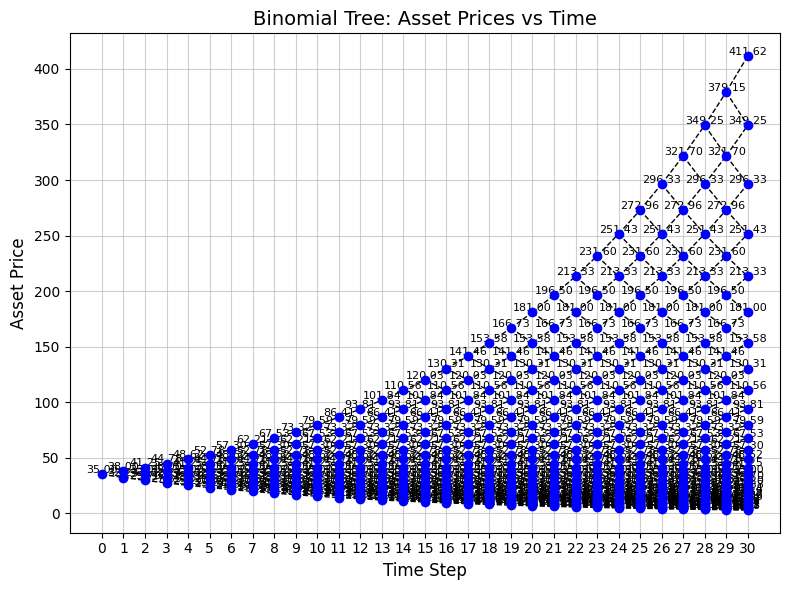

In [18]:
# Plot the binomial tree with asset prices on the y-axis
fig, ax = plt.subplots(figsize=(8, 6))

# Loop through the array to extract and plot the binomial tree
for i in range(N+1):
    for j in range(i+1):
        # Plot each node
        ax.scatter(i, asset_price[j, i], color="blue", zorder=5)  # Time step (x-axis), asset price (y-axis)
        # Annotate with asset price
        ax.text(i, asset_price[j, i] + 1, f"{asset_price[j, i]:.2f}", ha="center", fontsize=8)

        # Draw lines to child nodes if not at the last column
        if i < N:
            # Line to "up" node
            ax.plot([i, i+1], [asset_price[j, i], asset_price[j, i+1]], color="black", linestyle="--", linewidth=1)
            # Line to "down" node
            ax.plot([i, i+1], [asset_price[j, i], asset_price[j+1, i+1]], color="black", linestyle="--", linewidth=1)

# Customize the plot
ax.set_title("Binomial Tree: Asset Prices vs Time", fontsize=14)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Asset Price", fontsize=12)
ax.set_xticks(range(N+1))
ax.grid(True, linestyle="-", alpha=0.6)
plt.tight_layout()

### Precision of binomial trees

In [3]:
steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 100, 250, 500, 1000]
price_list = []

for step in steps:
    # Parameters
    S0 = 35
    K = 35
    r = 0.03
    sigma = 0.45
    T = 1
    q = 0.04

    N = step
    dt = T / N

    # Initialize asset price array
    asset_price = np.zeros((N+1, N+1))

    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Populate asset price array
    for i in range(N+1):
        for j in range(i+1):
            asset_price[j, i] = S0 * (u**(i-j)) * (d**j)

    # Probability and payoff initialization
    p = (np.exp((r - q) * dt) - d) / (u - d)
    payoff = np.zeros((N+1, N+1))

    # Backward induction for option payoff
    for i in range(N, -1, -1):
        for j in range(i+1):
            if i == N:  # At maturity
                payoff[j, i] = np.maximum((K - asset_price[j, i]), 0)
            else:  # Discounted expected payoff
                payoff[j, i] = ((p * payoff[j, i+1]) + ((1-p) * payoff[j+1, i+1])) * np.exp(-r * dt)

    price_list.append(round(payoff[0, 0], 3))

print(price_list)

[np.float64(7.647), np.float64(5.502), np.float64(6.682), np.float64(5.826), np.float64(6.483), np.float64(5.942), np.float64(6.397), np.float64(6.002), np.float64(6.35), np.float64(6.039), np.float64(6.245), np.float64(6.157), np.float64(6.172), np.float64(6.181), np.float64(6.184), np.float64(6.185)]


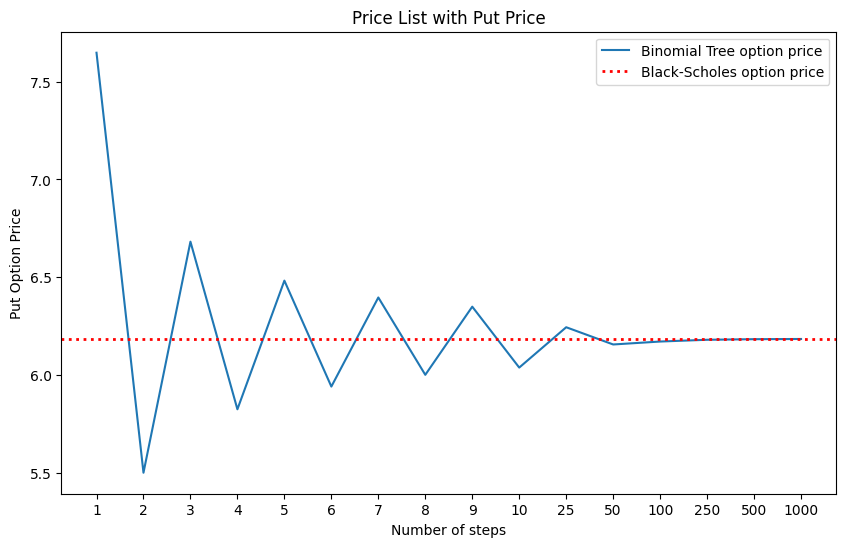

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(price_list)), price_list, label='Binomial Tree option price')
plt.axhline(y=put_price, color='red', linestyle=':', linewidth=2, label='Black-Scholes option price')
plt.xlabel('Number of steps')
plt.xticks(ticks=range(len(steps)), labels=steps)
plt.ylabel('Put Option Price')
plt.title('Price List with Put Price')
plt.legend()